# <center>**DummyMoon**<center>

**Libraries**

In [1]:
import numpy as np
import dummymoon as dm

In [2]:
root_path = "/mnt/d/PhD_AASS/Coding/Images_fits/"
mask_fits_file = root_path + "wfm_mask.fits"

**Loading Mask**

### Camera Parameters
mask_minx: -130.0
mask_miny: -130.0
mask_maxx: 130.0
mask_maxy: 130.0
mask_deltax: 0.25
mask_deltay: 0.4
mask_thickness: 0.15
slit_deltax: 0.25
slit_deltay: 14.0
detector_minx: -78.988
detector_maxx: 78.988
detector_miny: -76.5255
detector_maxy: 76.5255
mask_detector_distance: 202.9
open_fraction: 0.2157988165680473
real_open_fraction: 0.25048076923076923

### Shapes
Mask shape: (650, 1040)
Detector shape: (384, 632)
Sky shape: (1033, 1671)


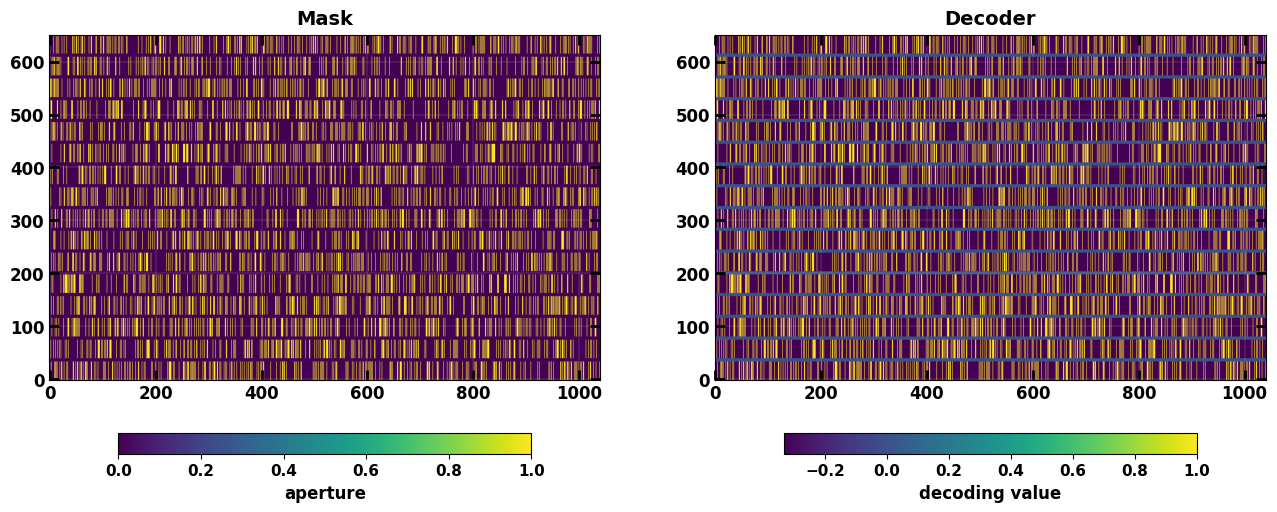

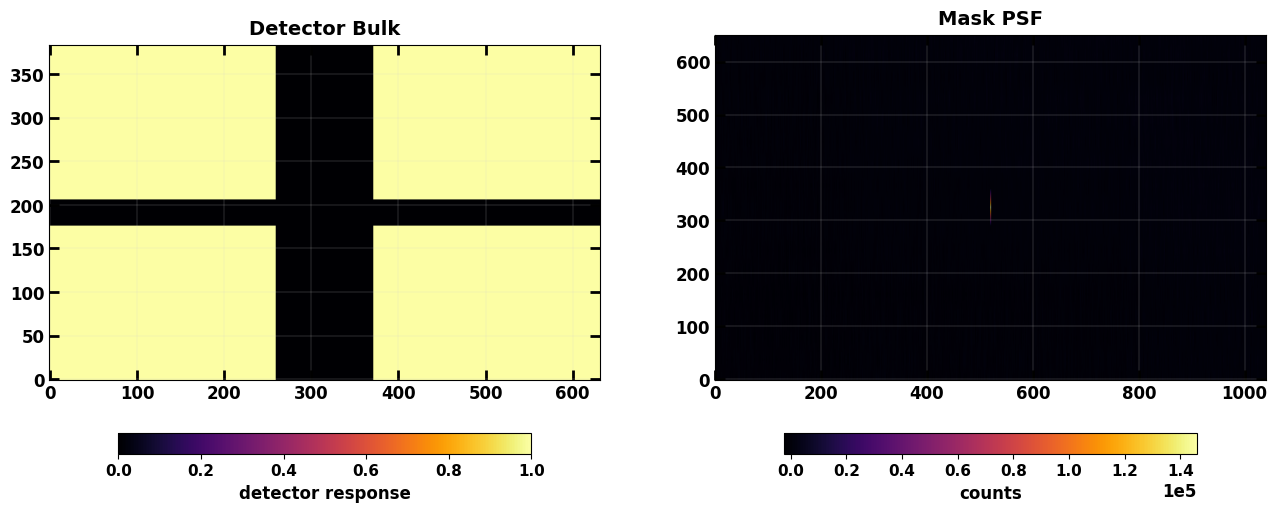

In [3]:
wfm = dm.import_mask(mask_fits_file, True, True)

**Simulating more realistic Sky**

In [4]:
exposure = 5e3   # [s]

n_sources = 20
sources_rates = np.random.randint(int(5e0), int(3e1), size=n_sources)   # [photons/s]
sources_pos = None   # [deg, deg]
skybg_rate = 260     # [photons/s]

detector, pxpos, _ = dm.skymap_simulation(
    exposure=exposure,
    sources_pos=sources_pos,
    sources_rates=sources_rates,
    skybg_rate=skybg_rate,
    cam=wfm,
)

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_38009/76245917.py:21: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["counts", "SNR[$\sigma$]"],


SNR Source [0] value: 133
SNR Source [1] value: 1336
SNR Source [2] value: 165
SNR Source [3] value: 1272
SNR Source [4] value: 743
SNR Source [5] value: 1728
SNR Source [6] value: 700
SNR Source [7] value: 236
SNR Source [8] value: 933
SNR Source [9] value: 484
SNR Source [10] value: 1080
SNR Source [11] value: 382
SNR Source [12] value: 586
SNR Source [13] value: 998
SNR Source [14] value: 235
SNR Source [15] value: 708
SNR Source [16] value: 1250
SNR Source [17] value: 731
SNR Source [18] value: 924
SNR Source [19] value: 1615


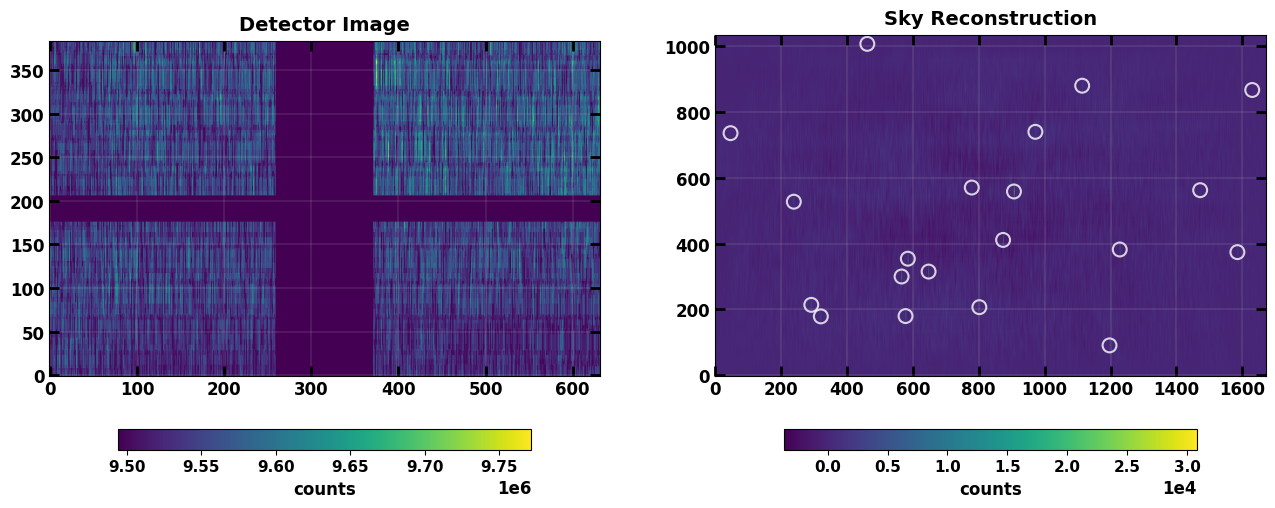

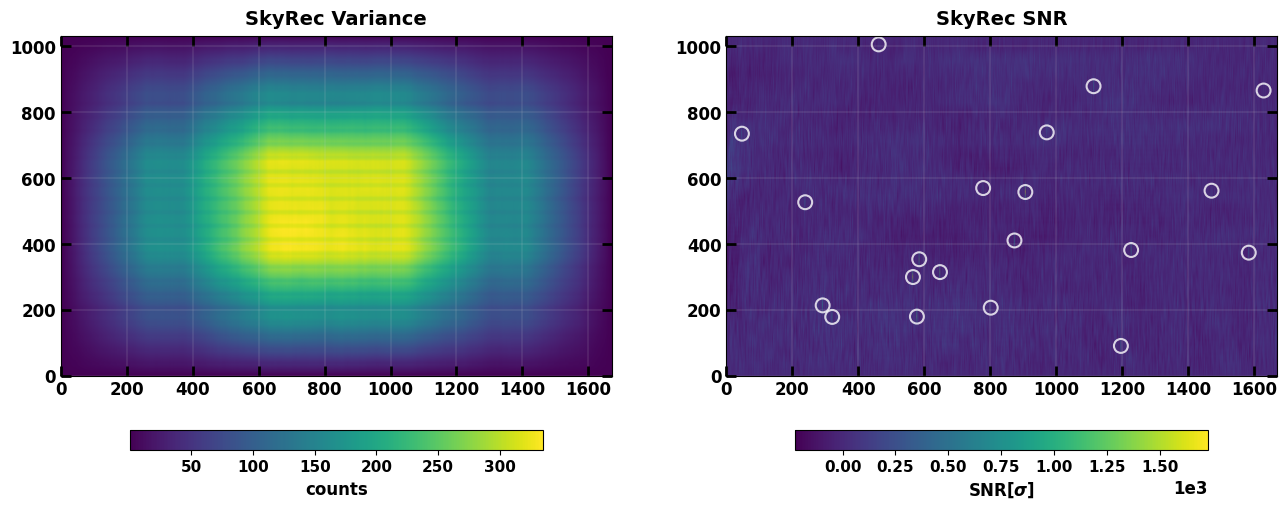

In [5]:
skyrec, skyvar = dm.sky_reconstruction(detector, wfm)
skysnr = dm.sky_snr(skyrec, skyvar)
skyrec, skyvar = dm.skyrec_norm(skyrec, skyvar, wfm)

for idx, pos in enumerate(pxpos):
    print(f"SNR Source [{idx}] value: {skysnr[*pos]:.0f}")

dm.image_plot([detector, skyrec],
              ["Detector Image", "Sky Reconstruction"],
              cbarlabel=["counts", "counts"],
              cbarlimits=[(np.unique(detector)[1], None), (None, None)],
              cbarscinot=[True]*2,
              cbarcmap=["viridis"]*2,
              simulated_sources=[None, pxpos])

# transmitted_photons = corr_sky*wfm.specs["real_open_fraction"]
# dm.print_skyrec_info(transmitted_photons, norm_skyrec, norm_skyvar, pxpos, False)

dm.image_plot([skyvar, skysnr],
              ["SkyRec Variance", "SkyRec SNR"],
              cbarlabel=["counts", "SNR[$\sigma$]"],
              cbarlimits=[(None, None), (None, None)],
              cbarscinot=[True]*2,
              cbarcmap=["viridis"]*2,
              simulated_sources=[None, pxpos])

show_snr_distr = False
if show_snr_distr: dm.show_snr_distr(skysnr)

<br>

<br>

<br>

**Let's apply IROS...**

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_38009/592418449.py:28: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["counts", "SNR[$\sigma$]"],


New source found at pos (558, 907)!
New source found at pos (300, 566)!
New source found at pos (315, 648)!
New source found at pos (354, 585)!
New source found at pos (411, 874)!
New source found at pos (382, 1228)!
New source found at pos (180, 578)!
New source found at pos (570, 779)!
New source found at pos (214, 292)!
New source found at pos (179, 321)!
New source found at pos (527, 239)!
New source found at pos (879, 1114)!
New source found at pos (739, 972)!
New source found at pos (91, 1197)!
New source found at pos (374, 1585)!
New source found at pos (207, 802)!
New source found at pos (562, 1472)!
New source found at pos (735, 47)!
Source pos (411, 874) already recorded...
Source pos (315, 648) already recorded...
Source pos (300, 566) already recorded...
New source found at pos (866, 1630)!
New source found at pos (1006, 462)!
Source pos (570, 779) already recorded...
Source pos (180, 578) already recorded...
No sources detected with SNR over 20...


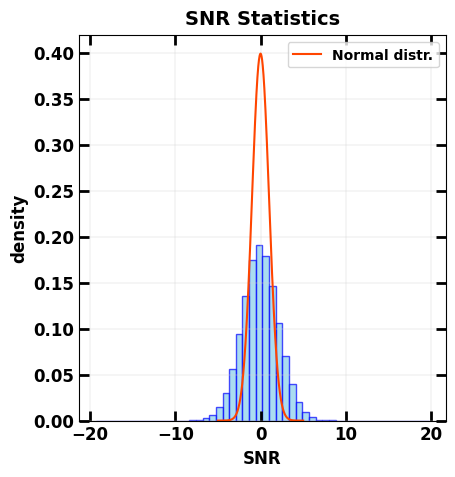

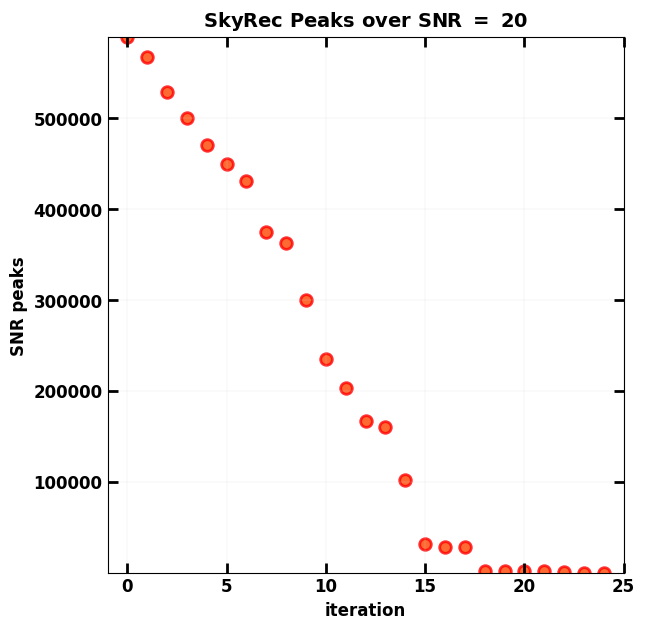

In [9]:
thres = 20
max_iter = 40

perform = True

if perform:

    loop = dm.IROS(
        data=detector,
        snr_threshold=thres,
        cam=wfm,
        max_iterations=max_iter,
        snr_distr=False, #(True, max_iter//4),
        snr_peaks=False #(True, max_iter//4),
    )

    show_cropping = False
    show_results = False

    for idx, obj in enumerate(loop):
        sky, var, snr, sources = obj

        if show_cropping and (idx % max_iter//4 == 0):
            k = 0
            print(f"Max SNR source pos: {sources['sources_pos'][k]}")
            dm.image_plot([dm.crop(sky, sources['sources_pos'][k], (30, 30)), dm.crop(snr, sources['sources_pos'][k], (30, 30))],
                        [f"Max SNR $S_{{{k}}}$ Reconstr.", f"Max SNR $S_{{{k}}}$ Value, iter. {idx}"],
                        cbarlabel=["counts", "SNR[$\sigma$]"],
                        cbarcmap=['viridis']*2)

        if show_results and (idx % max_iter//4 == 0):
            dm.image_plot([skyrec, sky],
                            ["Sky Reconstruction", f"SkyRec IROS, iter. {idx}"],
                            cbarlabel=["counts", "counts"],
                            cbarcmap=['viridis']*2,
                            simulated_sources=[pxpos]*2)

            dm.image_plot([snr, skyrec - sky],
                            [f"IROS iter. {idx} SNR", f"Residues: SkyRec - IROS{idx}"],
                            cbarlabel=["counts", "counts"],
                            cbarcmap=['viridis']*2,
                            simulated_sources=[pxpos]*2)

#### IROS Sky Reconstruction Run ####
 - simulated sources: 20
 - IROS rec. sources: 20 c:

# Source [0] Reconstruction:
  - simulated source transmitted counts: 30804 +/- 176
  - IROS rec. source counts: 30804 +/- 318
  - IROS rec. source SNR: 1728
  - source rec. counts wrt simulated: 100.00%

# Source [1] Reconstruction:
  - simulated source transmitted counts: 23941 +/- 155
  - IROS rec. source counts: 23999 +/- 219
  - IROS rec. source SNR: 1620
  - source rec. counts wrt simulated: 100.24%

# Source [2] Reconstruction:
  - simulated source transmitted counts: 21957 +/- 148
  - IROS rec. source counts: 22129 +/- 270
  - IROS rec. source SNR: 1347
  - source rec. counts wrt simulated: 100.78%

# Source [3] Reconstruction:
  - simulated source transmitted counts: 21039 +/- 145
  - IROS rec. source counts: 21733 +/- 273
  - IROS rec. source SNR: 1316
  - source rec. counts wrt simulated: 103.30%

# Source [4] Reconstruction:
  - simulated source transmitted counts: 17583 +/- 133
  - 

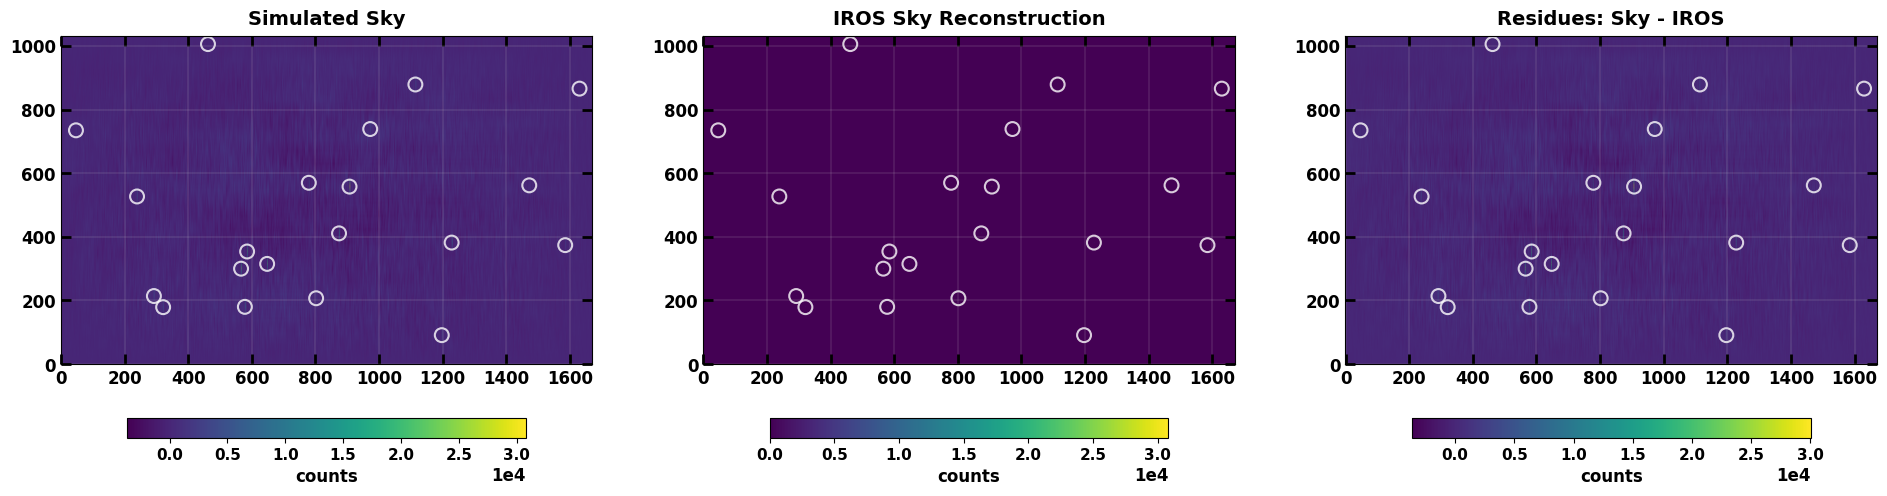

In [10]:
iros_sky, residues = dm.iros_skyrec(skyrec, pxpos, sources, wfm)

In [11]:
dm.iros_log(sources)

### IROS Sky Reconstruction Log ###
# Source [0] Log:
  - pos: (558, 907)
  - counts: 30804 +/- 318
  - SNR: 1728.24

# Source [1] Log:
  - pos: (300, 566)
  - counts: 23999 +/- 219
  - SNR: 1619.91

# Source [2] Log:
  - pos: (315, 648)
  - counts: 22129 +/- 270
  - SNR: 1347.27

# Source [3] Log:
  - pos: (354, 585)
  - counts: 21733 +/- 273
  - SNR: 1315.57

# Source [4] Log:
  - pos: (411, 874)
  - counts: 17962 +/- 310
  - SNR: 1020.38

# Source [5] Log:
  - pos: (382, 1228)
  - counts: 15329 +/- 203
  - SNR: 1074.75

# Source [6] Log:
  - pos: (180, 578)
  - counts: 15213 +/- 149
  - SNR: 1246.13

# Source [7] Log:
  - pos: (570, 779)
  - counts: 9567 +/- 317
  - SNR: 537.57

# Source [8] Log:
  - pos: (214, 292)
  - counts: 9355 +/- 87
  - SNR: 1004.07

# Source [9] Log:
  - pos: (179, 321)
  - counts: 8672 +/- 84
  - SNR: 945.58

# Source [10] Log:
  - pos: (527, 239)
  - counts: 8343 +/- 147
  - SNR: 688.01

# Source [11] Log:
  - pos: (879, 1114)
  - counts: 7615 +/- 119
  - 